# Project title : Understanding Fatal rate of Covid-19: How serious is this virus?

Dataset is from www.kaggle.com


In [1]:
## import everything needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy import stats
from sklearn import metrics
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score , recall_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
## read csv from local
df = pd.read_csv("Raw dataset.csv")
pd.pandas.set_option('display.max_columns',None)

## Simply take a look at the dataset



In [3]:
df.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,2,2,2,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,2,2,2,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,2,2,2,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,2,2,2,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,1,2,2,2,1,2,1,2,2,2,99,1,2


In [4]:
df.shape

(566602, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

As we can see from abovem it has 566602 row and 23 column
Attribute shown are patient detail including health issue, date(entry to hospital,symptoms,died) and test result


# Preprocessing Stage

Change date form

from yy-mm-dddd to dd-mm-yyyy

In [6]:
date_fields=['entry_date','date_symptoms']
for dates in date_fields:
    df[dates]=pd.to_datetime(df[dates],infer_datetime_format=True)

Replace certain value in data with nan



In [7]:
df.iloc[:,6:]=df.iloc[:,6:].replace([97,98,99],np.nan)

## Take a look at which attribute has null values

Text(0.5, 1.0, 'Null value heatmap')

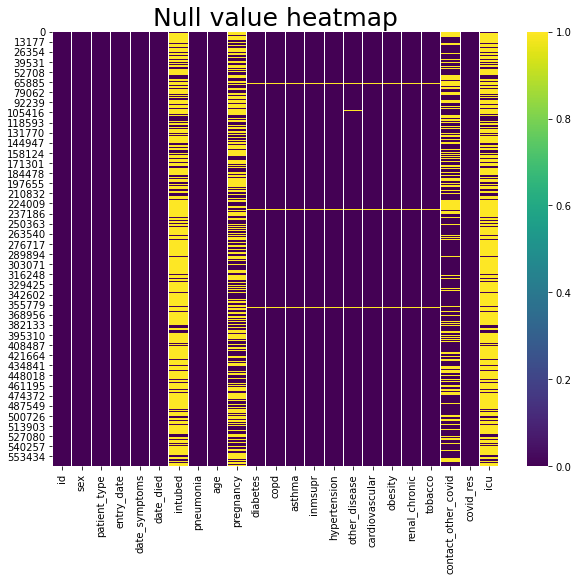

In [8]:
# Check which attribute has null values

plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(),cmap='viridis')
plt.title('Null value heatmap',size=25)

## Above heatmap show that intubed, pregnancy, contact other covid, icu has too many null values
## Simply perform imputation will actually decrease model performance

In [9]:
## drop column that has too much null values
## drop column that we don't need (date,...)

df=df[['sex', 'patient_type', 'date_died', 'age'
       , 'pneumonia', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco' ,
       'covid_res']]

##Replace null value with mode (appraoximate)

for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

## rename some column for easier readable
df.rename(columns={'covid_res':'Test result'},inplace=True)

Text(0.5, 1.0, 'Null value heatmap')

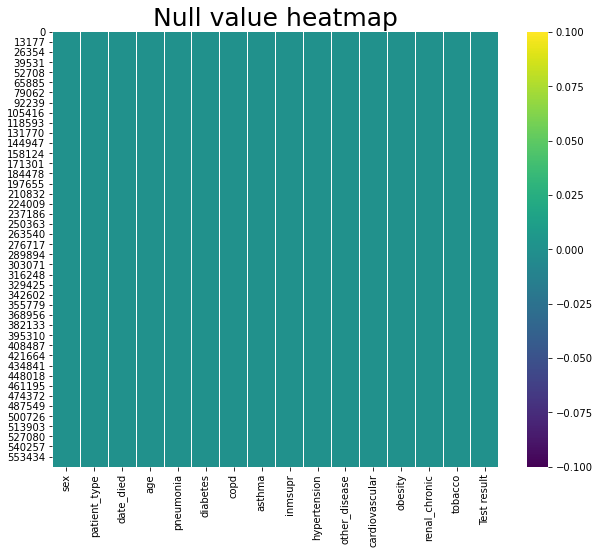

In [10]:
## check again where there is null value

plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(),cmap='viridis')
plt.title('Null value heatmap',size=25)

## For data_died column, we rename it to Fatal
### Value in this column is showing date of patients died.
### Value is 9999-99-99 when patients did not die

In [11]:
df.rename(columns={'date_died':'Fatal'},inplace=True)

df['Fatal'].replace('9999-99-99',0,inplace=True)
df["Fatal"][df["Fatal"] != 0] = 1

titles = list(df.columns)
titles
titles[2],titles[14] = titles[14],titles[2]
titles

df = df[titles]


In original dataset given, 1 = positive, 2 = negative
For easier understanding, we convert all value 2 into 0

Reminder : do not convert age column

In [12]:
## Replace value of 2(No) with 0 
df.iloc[:,:3]=df.iloc[:,:3].replace(2,0)
df.iloc[:,4:]=df.iloc[:,4:].replace(2,0)

### export cleaned dataset

In [13]:
df.to_csv("Cleaned dataset.csv")

## Since result is take from hospital, some covid test result are negative and waiting
### We filter out these value because we only focus on covid-19 patients

In [14]:
## our target is to investigate positive covid patient
## so drop negative result patients

df = df[df["Test result"] == 1]

In [15]:
#check test result

df['Test result'].value_counts()

1    220657
Name: Test result, dtype: int64

In [16]:
df = df.drop("Test result",axis = 1)

## In this project, the output column that we want to investigate is "Fatal"


In [17]:
##check fatality

df["Fatal"].value_counts()

0    193536
1     27121
Name: Fatal, dtype: int64

### Now we have final dataset

### Before performing classification, it is important to understand attributes

In [18]:
df.shape

(220657, 15)

In [19]:
df.head()

,sex,patient_type,tobacco,age,pneumonia,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,Fatal
0,0,1,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,1,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1,0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0,0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1,0,0.0,60.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1


In [20]:
## check which disease has actually increase the fatal rate
## formula = fatality rate for patient with disease a/fatality rate for patient w/o disease a
## if fatality with disease is higher, it means that particular disease increase fatality rate
## understanding this may help us to refined our model

def checkrate(disease):
    return (len(df[(df[disease] == 1) & (df.Fatal == 1)])/len(df[df[disease] == 1])) > (len(df[(df[disease] == 0) & (df.Fatal == 1)])/len(df[df[disease] == 0]))

disease = ["pneumonia","copd","asthma","inmsupr","hypertension","other_disease","cardiovascular","obesity","renal_chronic","tobacco"]

for i in disease:
    print(i , ":" ,checkrate(i))

pneumonia : True
copd : True
asthma : False
inmsupr : True
hypertension : True
other_disease : True
cardiovascular : True
obesity : True
renal_chronic : True
tobacco : True


# Start to train our model

In [21]:
## start to train our model 
## split train-test data

from sklearn.model_selection import train_test_split


X= df.drop("Fatal",axis = 1)
y= df["Fatal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
## Classifier 1 : Random Forest

def runRF(X_train, X_test):
    rfc1=RandomForestClassifier(criterion= 'gini', max_depth= 4, max_features= 'sqrt', n_estimators= 100)
    rfc1.fit(X_train, y_train)
    pred=rfc1.predict(X_test)
    return pred

# Evaluate performance

In [23]:
## Check performance

pred = runRF(X_train, X_test)
confusion_matrix(y_test,pred)

array([[38697,    39],
       [ 5346,    50]])

In [24]:
def check_performance(func, y_test):
    pred  = func
    print("Recall rate for Random Forest on CV data: ",recall_score(y_test,pred))
    print("F1 for Random Forest on CV data: ",f1_score(y_test,pred))
    print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))
    print("Precision for Random Forest on CV data: ",precision_score(y_test,pred))

def list_performance(classifier,y_test):
    return [recall_score(y_test,classifier),f1_score(y_test,classifier),accuracy_score(y_test,classifier),precision_score(y_test,classifier)]

In [25]:
check_performance(runRF(X_train, X_test), y_test)

Recall rate for Random Forest on CV data:  0.014825796886582653
F1 for Random Forest on CV data:  0.02892263195950831
Accuracy for Random Forest on CV data:  0.8782742681047766
Precision for Random Forest on CV data:  0.5882352941176471


## Because dataset is imbalanced,  thus performace for this model has no reference value.

In [26]:
df["Fatal"].value_counts()

0    193536
1     27121
Name: Fatal, dtype: int64

### reduced the dataset of "Fatal" = 2 to 15% of original size

In [27]:
df_reduced_2 = df[df["Fatal"] == 0]
df_final = df_reduced_2.sample(frac = 0.15)

df_reduced_1 = df[df["Fatal"] == 1]


In [28]:
df_final = df_final.append(df_reduced_1)

In [55]:
df_final["Fatal"].value_counts()

0    29030
1    27121
Name: Fatal, dtype: int64

# Using undersampling data

In [30]:
X = df_final.drop("Fatal", axis = 1)
y = df_final['Fatal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Classifier 1 : Random Forest

In [31]:
pred = runRF(X_train, X_test)
confusion_matrix(y_test,pred)

array([[4527, 1219],
       [ 410, 5075]])

In [32]:
check_performance(runRF(X_train, X_test), y_test)
rf_accuracy = accuracy_score(y_test,pred)



Recall rate for Random Forest on CV data:  0.9152233363719234
F1 for Random Forest on CV data:  0.8595154524441401
Accuracy for Random Forest on CV data:  0.8538865639747129
Precision for Random Forest on CV data:  0.8102001291155584


## Classifier 2 : Logistic Regression

In [33]:
def runLR(X_train, X_test):
    
    lrmodel = LogisticRegression(solver='lbfgs')
    lrmodel.fit(X_train, y_train)
    pred = lrmodel.predict(X_test)
    return pred

In [34]:
confusion_matrix(y_test,runLR(X_train, X_test))

array([[4713, 1033],
       [ 668, 4817]])

In [35]:
check_performance(runLR(X_train, X_test), y_test)
lr_accuracy = accuracy_score(y_test,pred)





Recall rate for Random Forest on CV data:  0.8782133090246126
F1 for Random Forest on CV data:  0.8499338332598149
Accuracy for Random Forest on CV data:  0.8485442079957262
Precision for Random Forest on CV data:  0.8234188034188035


## Naive Bayes, KNN, SVM

In [36]:
def runNB(X_train, X_test):
    model = GaussianNB()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    return pred

def runKNN(X_train, X_test):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return pred

def runSVM(X_train, X_test):
    model = svm.SVC()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return pred
    

In [37]:
classifier = {"RandomForest" : runRF(X_train, X_test) , "LogisticRegression" : runLR(X_train, X_test),
              "NaiveBayes" : runNB(X_train, X_test), "KNearestNeighbour" : runKNN(X_train, X_test),
             "SupportVectorMachine" : runSVM(X_train, X_test)}
def view_performance(X_train, X_test):   
    performance = {}
    for i in classifier:
        performance[i] = list_performance(classifier[i],y_test)
    return pd.DataFrame.from_dict(performance, orient='index',columns=['Recall', 'F1', 'Accuracy', 'Precision'])
    

base_performance = view_performance(X_train, X_test)

In [38]:
base_performance

,Recall,F1,Accuracy,Precision
RandomForest,0.922151,0.861596,0.855311,0.808504
LogisticRegression,0.878213,0.849934,0.848544,0.823419
NaiveBayes,0.746399,0.777366,0.791203,0.811014
KNearestNeighbour,0.848861,0.825898,0.825216,0.804145
SupportVectorMachine,0.901732,0.843236,0.836257,0.791867


In [46]:
base_performance.index

Index(['RandomForest', 'LogisticRegression', 'NaiveBayes', 'KNearestNeighbour',
       'SupportVectorMachine'],
      dtype='object')

<AxesSubplot:xlabel='Algorithms', ylabel='Accuracy'>

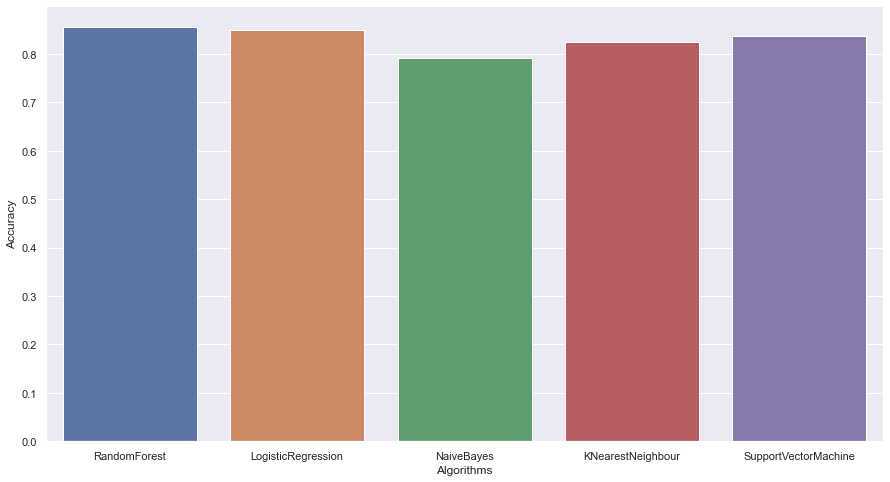

In [47]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(base_performance.index,base_performance.Accuracy)

## Model improvement using feature selection method

In [39]:
# example of mutual information feature selection for categorical data

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from matplotlib import pyplot
 

## Check feature importance score using mutual information

sex: 0.009183
patient_type: 0.251501
tobacco: 0.000000
age: 0.152604
pneumonia: 0.192539
diabetes: 0.037449
copd: 0.006596
asthma: 0.002134
inmsupr: 0.002489
hypertension: 0.042831
other_disease: 0.002688
cardiovascular: 0.000429
obesity: 0.000404
renal_chronic: 0.002312


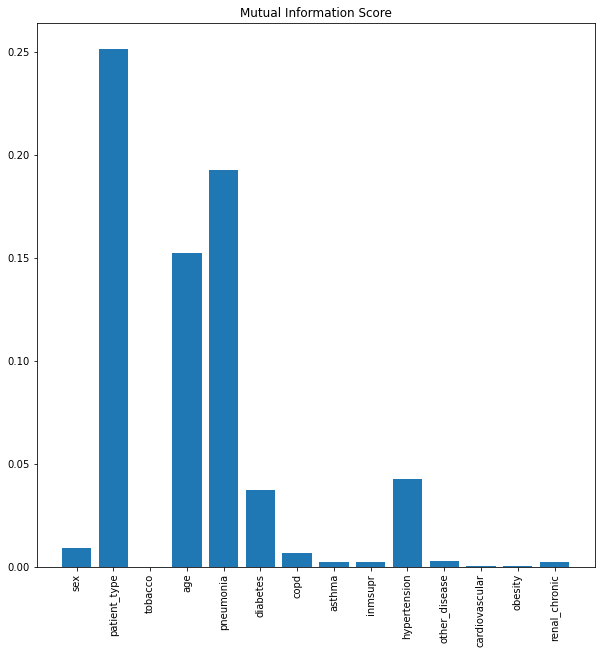

In [40]:
# feature selection using mutual information
def select_features_mi(X_train, y_train, X_test, k):
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features_mi(X_train, y_train, X_test, 5)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('%s: %f' % (df.columns[i], fs.scores_[i]))
# plot the scores
plt.figure(figsize=(10,10))
pyplot.bar(df.columns[:-1], list(fs.scores_))
plt.xticks(rotation='vertical')
plt.title("Mutual Information Score")
plt.savefig('mutual information.png',dpi = 200) 
pyplot.show()

## Check feature importance score using chi square

sex: 458.663409
patient_type: 11051.942384
tobacco: 9.381409
age: 65482.140132
pneumonia: 8846.186554
diabetes: 2463.048083
copd: 509.310045
asthma: 26.686100
inmsupr: 194.544134
hypertension: 2588.321394
other_disease: 189.882946
cardiovascular: 381.617786
obesity: 202.194579
renal_chronic: 773.460870


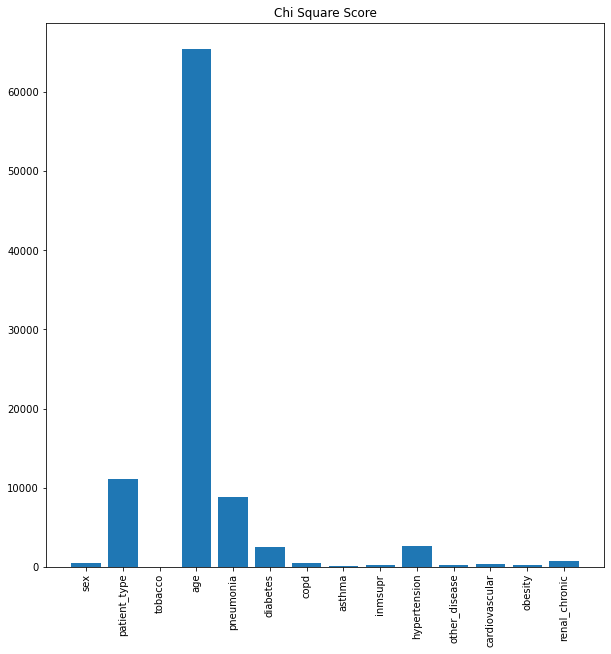

In [41]:
def select_features_chi2(X_train, y_train, X_test, k ):
    fs = SelectKBest(score_func=chi2, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features_chi2(X_train, y_train, X_test,5)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('%s: %f' % (df.columns[i], fs.scores_[i]))
# plot the scores
plt.figure(figsize=(10,10))
pyplot.bar(df.columns[:-1], list(fs.scores_))
plt.xticks(rotation='vertical')
plt.title("Chi Square Score")
plt.savefig('chi2.png',dpi = 150) 
pyplot.show()

## Train with only top 4 features

In [42]:
X_train_fs, X_test_fs, fs = select_features_mi(X_train, y_train, X_test, 4)

In [43]:
classifier = {"RandomForest" : runRF(X_train_fs, X_test_fs) , "LogisticRegression" : runLR(X_train_fs, X_test_fs),
              "NaiveBayes" : runNB(X_train_fs, X_test_fs), "KNearestNeighbour" : runKNN(X_train_fs, X_test_fs),
             "SupportVectorMachine" : runSVM(X_train_fs, X_test_fs)}

fsperformance = view_performance(X_train_fs, y_train)
fsperformance

,Recall,F1,Accuracy,Precision
RandomForest,0.926892,0.861403,0.854332,0.804558
LogisticRegression,0.875843,0.846968,0.845428,0.819935
NaiveBayes,0.874202,0.845083,0.843469,0.817841
KNearestNeighbour,0.876026,0.839081,0.835901,0.805127
SupportVectorMachine,0.899180,0.842429,0.835723,0.792416


<AxesSubplot:xlabel='Algorithms', ylabel='Accuracy'>

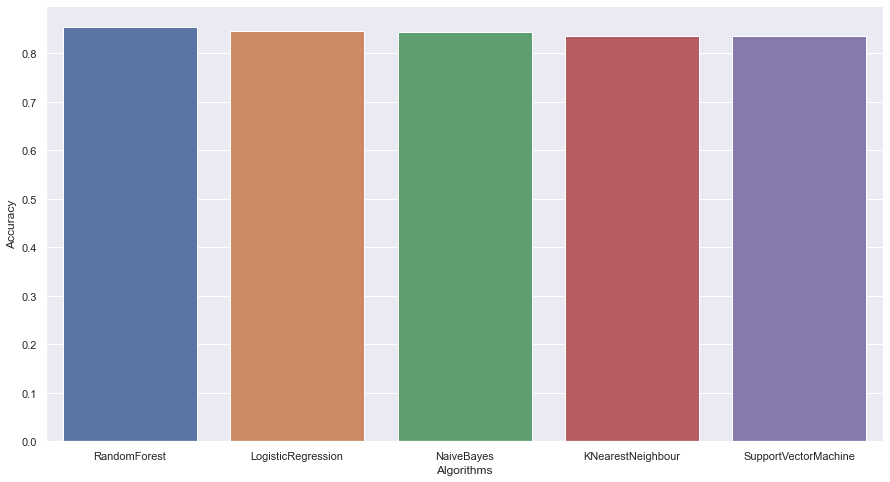

In [62]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(fsperformance.index,fsperformance.Accuracy)

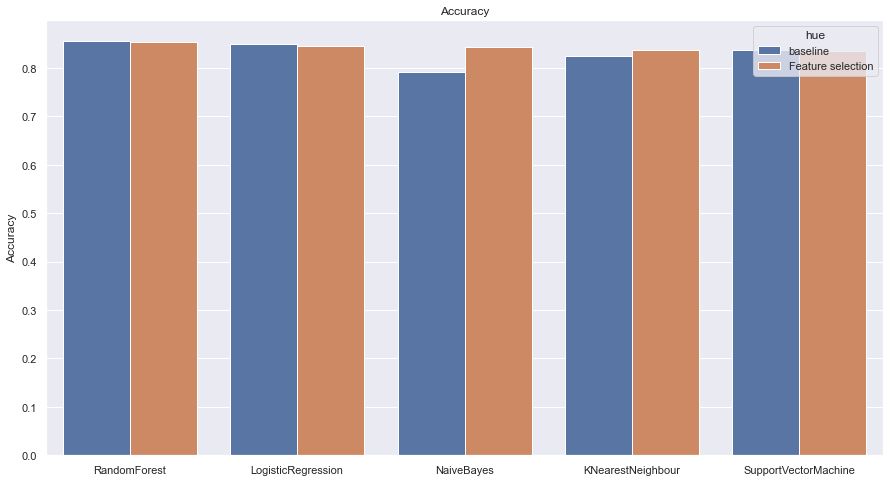

In [78]:
base_performance['hue']= "baseline"
fsperformance['hue']= "Feature selection"
res=pd.concat([base_performance,fsperformance])

sns.barplot(x= res.index,y='Accuracy',data=res,hue='hue')
plt.title("Accuracy")
plt.show()

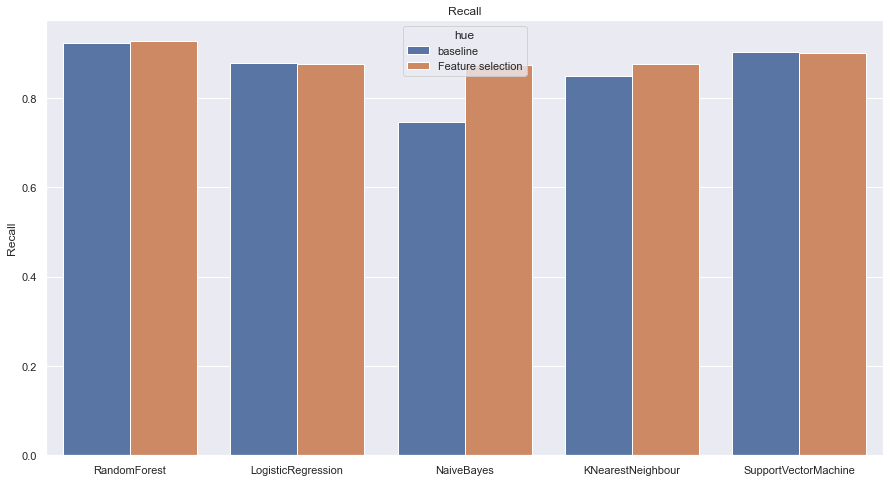

In [79]:
base_performance['hue']= "baseline"
fsperformance['hue']= "Feature selection"
res=pd.concat([base_performance,fsperformance])

sns.barplot(x= res.index,y='Recall',data=res,hue='hue')
plt.title("Recall")
plt.show()

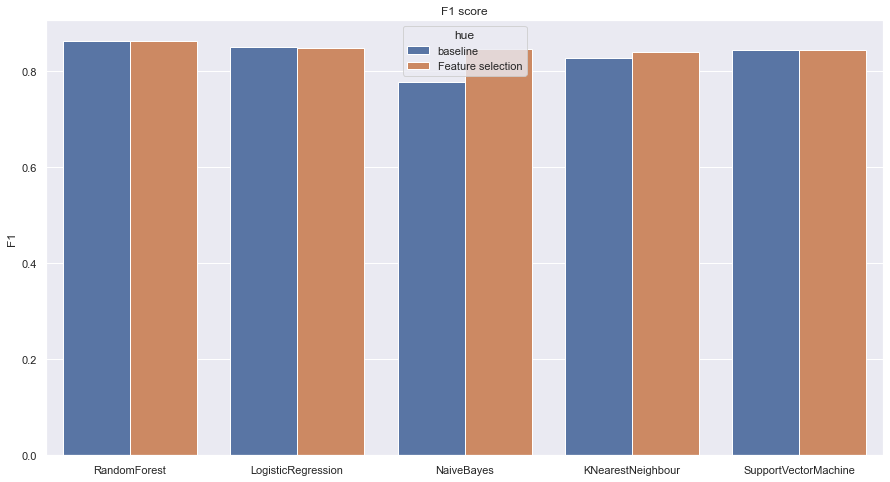

In [80]:
base_performance['hue']= "baseline"
fsperformance['hue']= "Feature selection"
res=pd.concat([base_performance,fsperformance])

sns.barplot(x= res.index,y='F1',data=res,hue='hue')
plt.title("F1 score")
plt.show()

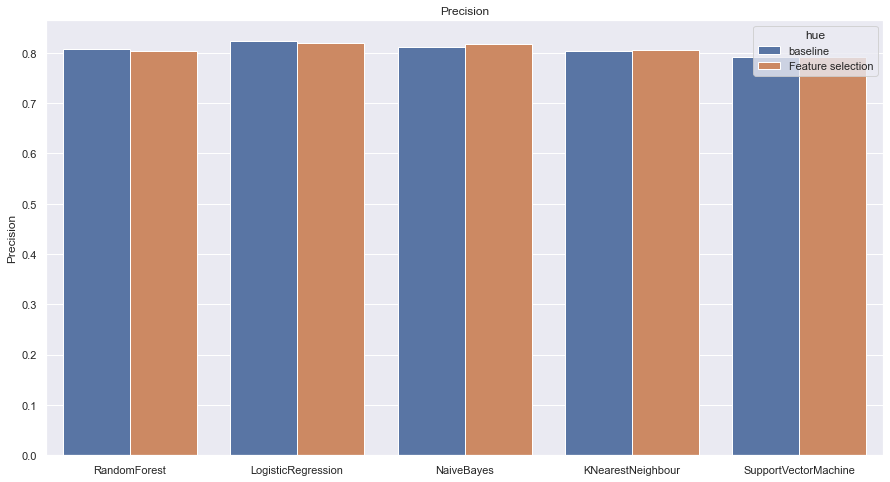

In [81]:
base_performance['hue']= "baseline"
fsperformance['hue']= "Feature selection"
res=pd.concat([base_performance,fsperformance])

sns.barplot(x= res.index,y='Precision',data=res,hue='hue')
plt.title("Precision")
plt.show()

In [83]:
!python --version

Python 3.8.5
